In [3]:
import pandas as pd
import numpy as np

In [4]:
df = pd.read_csv('diabetes_prediction_dataset.csv')

In [5]:
df.head(5)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [6]:
df.shape

(100000, 9)

# Data Preprocessing


In [7]:
df['diabetes'].value_counts()

diabetes
0    91500
1     8500
Name: count, dtype: int64

__Imbalnced Data__

we might need to consider sampling techniques, although we will first check model performance without sampling.

In [8]:
df['smoking_history'].value_counts()

smoking_history
No Info        35816
never          35095
former          9352
current         9286
not current     6447
ever            4004
Name: count, dtype: int64

> smoking_history column has **No Info category** which is can be considered as **NaN value**

In [9]:
df['smoking_history']=df['smoking_history'].replace('No Info', np.nan)

In [10]:
df.isnull().sum()

gender                     0
age                        0
hypertension               0
heart_disease              0
smoking_history        35816
bmi                        0
HbA1c_level                0
blood_glucose_level        0
diabetes                   0
dtype: int64

## Imputing missing values of smoking history

In [11]:
def SmokingHistoryImpute(data,column):
     # Create a boolean mask for missing values in the column
    mask = data[column].isnull()
    
    # Count the number of missing values
    num_missing = mask.sum()
    
    # If there are missing values, sample non-null values from the column
    if num_missing > 0:
        # Sample values from non-null entries in the column
        random_sample = data[column].dropna().sample(num_missing, replace=True)
        
        # Assign these random values to the missing values in the column
        data.loc[mask, column] = random_sample.values

In [12]:
SmokingHistoryImpute(df,'smoking_history')

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report

## Data Encoding

In [14]:
X = df.drop(columns=['diabetes'])
y = df.iloc[:,-1]

In [15]:
oe_order = ['never','former','not current','current','ever']
preprocessor = ColumnTransformer(transformers=[
    ('oe',OrdinalEncoder(categories=[oe_order]),['smoking_history']),
    ('ohe', OneHotEncoder(drop='first'),['gender']),
    ('scaaler',MinMaxScaler(),['age','bmi','blood_glucose_level','HbA1c_level'])
],remainder='passthrough')

In [16]:
X_trf = preprocessor.fit_transform(X)

# Model training without handling imbalance

In [17]:
X_train,X_test,y_train,y_test = train_test_split(X_trf,y,test_size=0.2,random_state=42)

In [18]:
rf = RandomForestClassifier()

In [19]:
rf.fit(X_train,y_train)

RandomForestClassifier()

In [20]:
y_pred = rf.predict(X_test)

In [21]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     18292
           1       0.93      0.69      0.80      1708

    accuracy                           0.97     20000
   macro avg       0.95      0.84      0.89     20000
weighted avg       0.97      0.97      0.97     20000



In [22]:
f1_score(y_test,y_pred)

0.795439302481556

In [23]:
confusion_matrix(y_test,y_pred)

array([[18204,    88],
       [  522,  1186]], dtype=int64)

* __Class 0 (Non-diabetic):__

1. Precision (0.97): Out of all the instances predicted as non-diabetic, 97% were correctly identified as non-diabetic.
2. Recall (1.00): The model successfully identified all actual non-diabetic cases, meaning it didn’t miss any non-diabetic instances.
3. F1-Score (0.98): The F1-score, which balances precision and recall, is very high, indicating excellent performance for predicting non-diabetic cases.

* __Class 1 (Diabetic):__
1. Precision (0.94): Out of all the instances predicted as diabetic, 94% were correctly classified as diabetic.
2. Recall (0.69): The model only captured 69% of the actual diabetic cases, meaning 31% of true diabetic cases were missed by the model.
3. F1-Score (0.80): This shows the model's ability to handle diabetic cases, though the lower recall pulls down the F1-score.

* __Conclusion:__
1. We can clearly see model is biased towards majority class(i.e Non Diabetic) so we have used any one of the sampling technique to overcome imbalance in dataset
2. Although, it can deviate in some degree from real world situation but it can acceptable.


# Handling Imbalance using SMOTE technique

* __Combining Oversampling and Undersampling:__ SMOTETomek combines SMOTE (Synthetic Minority Over-sampling Technique) and Tomek links. SMOTE oversamples the minority class by creating synthetic samples, while Tomek links are used to undersample by removing overlapping or noisy examples from the majority class.

* __Reducing Class Overlap:__ SMOTETomek helps to reduce class overlap by removing Tomek links, which are pairs of instances (one from the majority class and one from the minority class) that are closest to each other and likely to be misclassified.

In [24]:
from imblearn.combine import SMOTETomek
sm=SMOTETomek(random_state=42)

In [25]:
X_resample,y_resample=sm.fit_resample(X_trf,y)

In [26]:
y_resample.value_counts()

diabetes
0    90759
1    90759
Name: count, dtype: int64

In [27]:
X_train_rs,X_test_rs,y_train_rs,y_test_rs = train_test_split(X_resample,y_resample,test_size=0.2,random_state=42)

In [28]:
clf = RandomForestClassifier()

In [29]:
clf.fit(X_train_rs,y_train_rs)

RandomForestClassifier()

In [30]:
y_pred_rs = clf.predict(X_test_rs)

In [31]:
print(classification_report(y_test_rs,y_pred_rs))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     18141
           1       0.98      0.98      0.98     18163

    accuracy                           0.98     36304
   macro avg       0.98      0.98      0.98     36304
weighted avg       0.98      0.98      0.98     36304



In [32]:
f1_score(y_test_rs,y_pred_rs)

0.980221714851594

In [33]:
confusion_matrix(y_test_rs,y_pred_rs)

array([[17768,   373],
       [  346, 17817]], dtype=int64)

**Conclusion:**
* We can see significant improvement in f1_score after sampling data**(from 0.79 to 0.98)**.

# Cross validation for sampled data using cross val

In [34]:
from sklearn.model_selection import cross_val_score
cross_val_score(clf,X_resample, y_resample, cv=5, scoring='f1',verbose=1,n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.9s finished


array([0.95182748, 0.98645327, 0.98369966, 0.98509419, 0.98552703])

__Cross val conclusion:__
* Cross val scores for **5 folds** can confirm our **model is not iverfitting**, whereas 1 out of 5 folds had underperformed but it can be acceptable.

# ROC-AUC plot for minority class comparison

In [35]:
y_proba = rf.predict_proba(X_test)[:,1]
y_proba_rs = clf.predict_proba(X_test_rs)[:,1]

# Precision Recall curve for minority class comparision

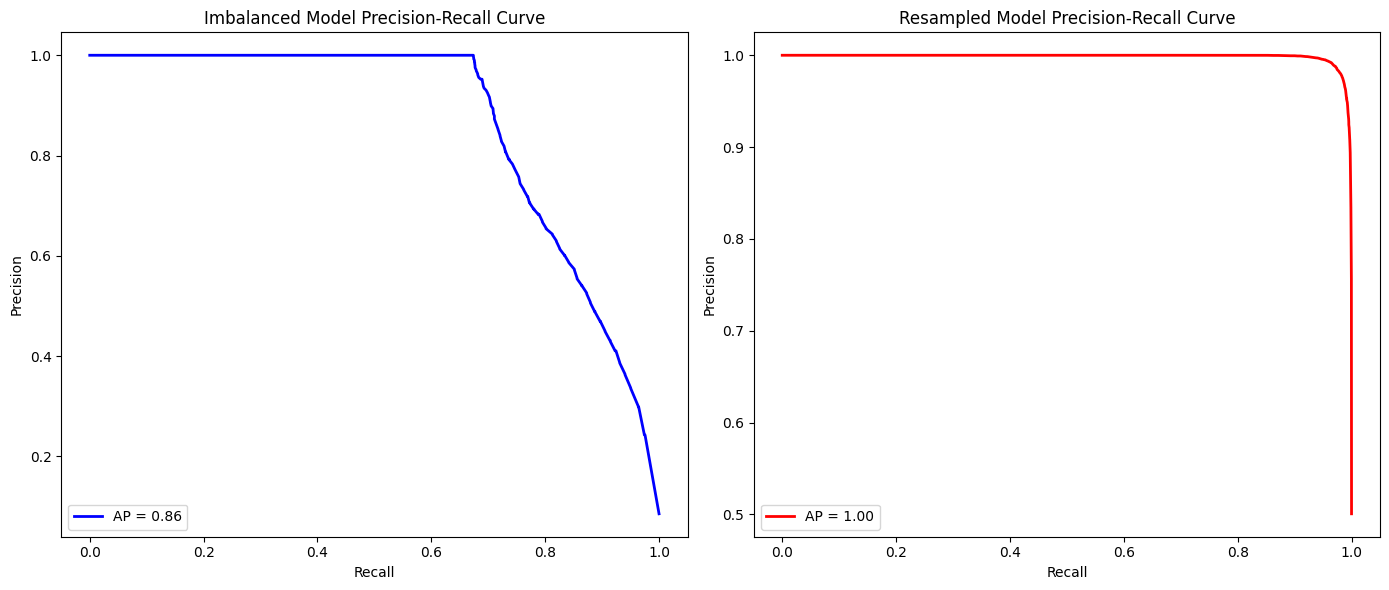

In [ ]:

# Compute Precision-Recall curve and average precision score for both models
precision, recall, _ = precision_recall_curve(y_test, y_proba)
average_precision = average_precision_score(y_test, y_proba)

precision_rs, recall_rs, _ = precision_recall_curve(y_test_rs, y_proba_rs)
average_precision_rs = average_precision_score(y_test_rs, y_proba_rs)

# Create subplots: two PR curves side by side
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot PR curve for the imbalanced model
ax[0].plot(recall, precision, color='blue', lw=2, label=f'AP = {average_precision:.2f}')
ax[0].set_xlabel('Recall')
ax[0].set_ylabel('Precision')
ax[0].set_title('Imbalanced Model Precision-Recall Curve')
ax[0].legend(loc="lower left")

# Plot PR curve for the resampled model
ax[1].plot(recall_rs, precision_rs, color='red', lw=2, label=f'AP = {average_precision_rs:.2f}')
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_title('Resampled Model Precision-Recall Curve')
ax[1].legend(loc="lower left")

# Adjust spacing between plots
plt.tight_layout()

# Show plots
plt.show()